In [127]:
from orbitflows import HamiltonianMappingModel, generate_sho_orbits
import matplotlib.pyplot as plt
import numpy as np
import torch
from orbitflows import H
from time import time

In [132]:
model = HamiltonianMappingModel(input_dim=2, hidden_dim=128, num_layers=64)
model.flow

GsympNetFlow(
  (layers): ModuleList(
    (0-63): 64 x SymplecticCouplingLayer(
      (conditioner): GradientBasedConditioner()
    )
  )
)

In [234]:
n_actions = 1
n_angles = 1000
r_min = 0.5
r_max = 1.5
omega_guess = 1
training_data, aa_guess = generate_sho_orbits(n_actions, omega=omega_guess, t_end=10, n_steps=n_angles, r_bounds=[r_min,r_max]) #

Text(0.5, 1.0, 'Toy Orbits')

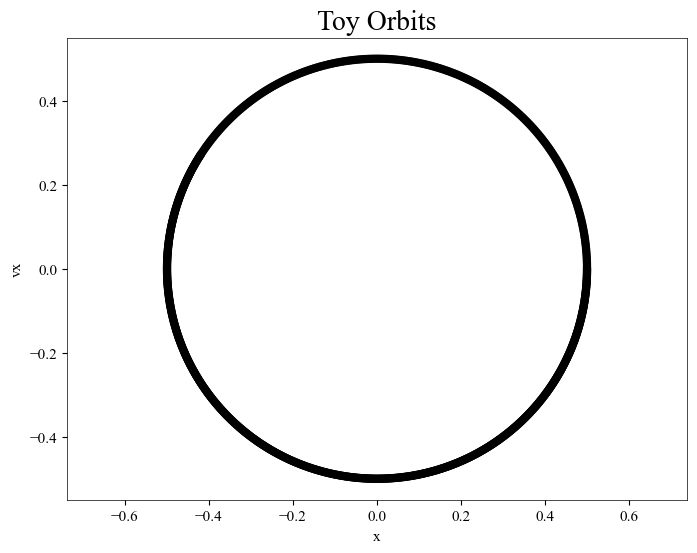

In [235]:
plt.scatter(*training_data.T)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('vx')
plt.title('Toy Orbits', fontsize=20)

In [311]:
def isoDiskPotential(x, amp=1, sigma=0.1):
    _H = sigma / torch.sqrt(torch.tensor([8.0 * torch.pi * amp]))[0]
    _sigma2 = sigma**2
    return 2.0 * _sigma2 * torch.log(torch.cosh(0.5 * x / _H))

steps = 200
model.train(isoDiskPotential, training_data, steps, learning_rate=1e-4)

100%|██████████| 200/200 [00:12<00:00, 16.31it/s]


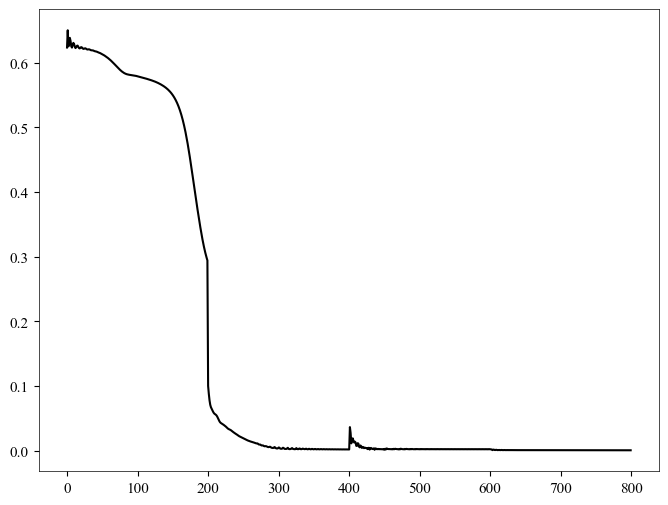

In [312]:
plt.plot(model.loss_list)

Text(0, 0.5, 'energy')

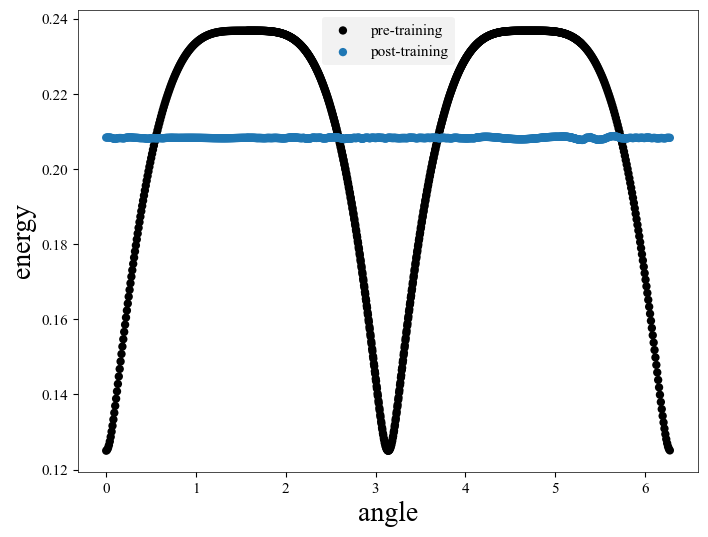

In [313]:
plt.scatter(aa_guess[...,0], H(training_data, model.targetPotential).detach(), label='pre-training')
plt.scatter(aa_guess[...,0], model.hamiltonian(aa_guess).detach(), label='post-training')
plt.legend()
plt.xlabel('angle', fontsize=20)
plt.ylabel('energy', fontsize=20)

In [314]:
aa0 = aa_guess[0][0].clone().requires_grad_()

In [382]:
euler_steps = 500
t_end = 1

st = time()
aa_euler_step = model.integrate(aa0, euler_steps, t_end)
euler_duration = time() - st

100%|██████████| 500/500 [00:21<00:00, 23.53it/s]


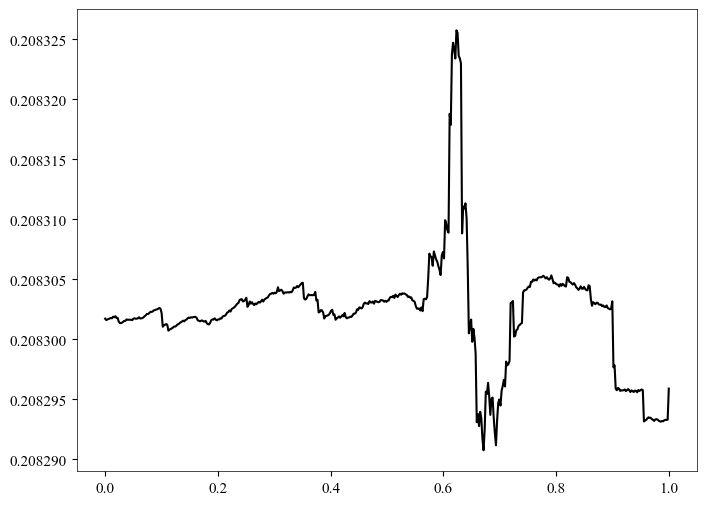

In [383]:
plt.plot(np.linspace(0, t_end, euler_steps), model.hamiltonian(aa_euler_step).detach(), label='euler')

In [384]:
from orbitflows.integrate import rungekutta4 as rk4

In [385]:
rk4_steps = int(euler_steps)
st = time()
aa_rk4 = model.integrate(aa0, rk4_steps, t_end, correction=rk4)
duration_rk4 = time() - st

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:05<00:00,  7.61it/s]


Text(0, 0.5, 'energy')

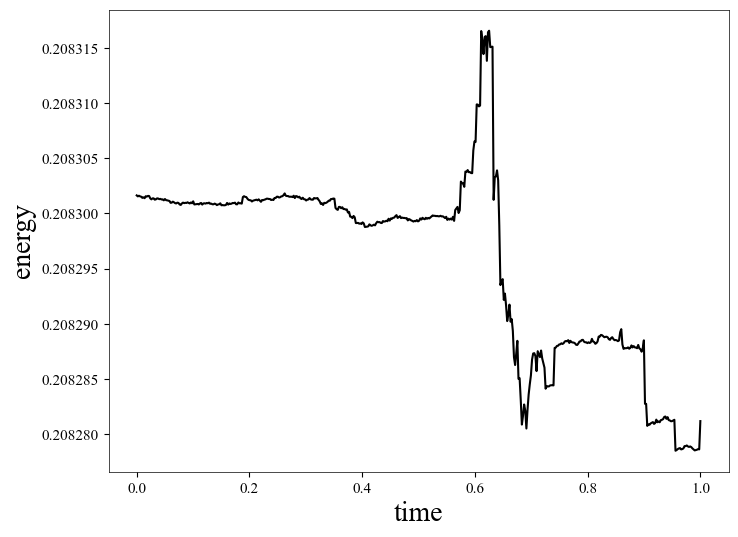

In [386]:
plt.plot(np.linspace(0, t_end, rk4_steps), model.hamiltonian(aa_rk4).detach())
plt.xlabel('time', fontsize=20)
plt.ylabel('energy', fontsize=20)

Text(0, 0.5, 'energy')

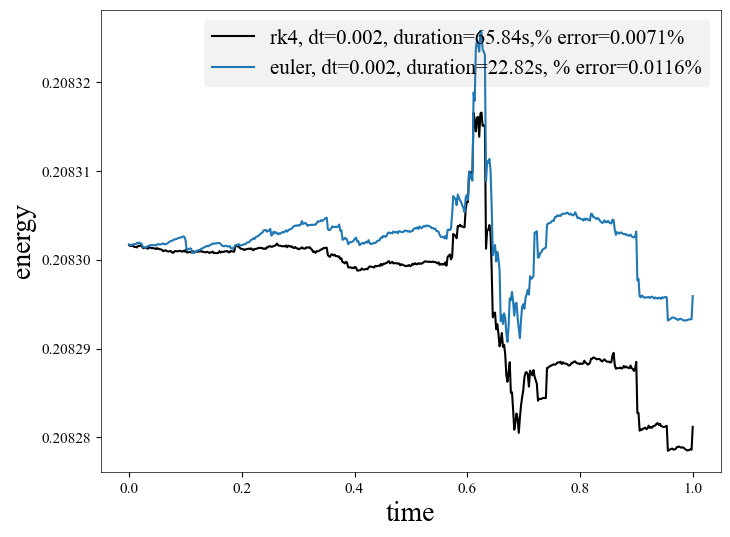

In [400]:
euler_percent_error = np.max(100 * ((model.hamiltonian(aa_euler_step).detach() - model.hamiltonian(aa0).detach()) / model.hamiltonian(aa0).detach()).numpy())
rk4_percent_error = np.max(100 * ((model.hamiltonian(aa_rk4).detach() - model.hamiltonian(aa0).detach()) / model.hamiltonian(aa0).detach()).numpy())
plt.plot(np.linspace(0, t_end, rk4_steps), model.hamiltonian(aa_rk4).detach(), label=f'rk4, dt={t_end/rk4_steps}, duration={duration_rk4:.2f}s,% error={rk4_percent_error:.4f}%')
plt.plot(np.linspace(0, t_end, euler_steps), model.hamiltonian(aa_euler_step).detach(), label=f'euler, dt={t_end/euler_steps}, duration={euler_duration:.2f}s, % error={euler_percent_error:.4f}%')
plt.legend(fontsize=15)

plt.xlabel('time', fontsize=20)
plt.ylabel('energy', fontsize=20)

In [401]:
rk4_percent_error

np.float32(0.007146491)

## compared to actionAngleVertical and numerical integration

In [402]:
aa0

tensor([1.5708, 0.1250], requires_grad=True)

In [403]:
ps0 = model.aa_to_ps(aa_rk4[0])

In [404]:
H(ps0, model.targetPotential).detach()

tensor(0.2083)

### numerical integration

In [394]:
from galpy.orbit import Orbit
o_lf = Orbit(ps0.detach().numpy())
st = time()
lf_steps = 100
o_lf.integrate(np.linspace(0, t_end, lf_steps), pot=IsothermalDiskPotential() , method='leapfrog')
duration_lf = time() - st

### aAVI

In [395]:
from galpy.actionAngle import actionAngleVerticalInverse, actionAngleVertical
from galpy.potential import IsothermalDiskPotential

In [396]:
aAV = actionAngleVertical(pot=IsothermalDiskPotential())
j0, _, theta0 = aAV.actionsFreqsAngles(float(ps0.detach()[0]),float(ps0.detach()[1]))

In [397]:
# aAVI = actionAngleVerticalInverse(pot=IsothermalDiskPotential(), Es=np.linspace(0, 1, 1000), setup_interp=True)
# st = time()
# q_aAVI, p_aAVI = aAVI(j0, aa_guess[0][..., 0].detach().numpy())
# duration_aAVI = time() - st

In [398]:
ps_aAVI = torch.stack([torch.tensor(q_aAVI), torch.tensor(p_aAVI)], dim=-1)

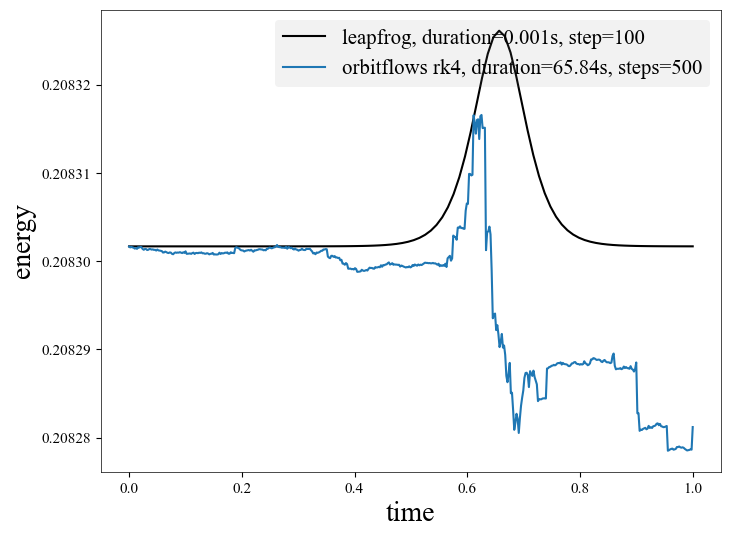

In [399]:
plt.plot(o_lf.time(), o_lf.E(o_lf.time()), label=f'leapfrog, duration={duration_lf:.3f}s, step={lf_steps}')
#plt.plot(np.linspace(0, t_end, len(ps_aAVI)), H(ps_aAVI, isoDiskPotential), label=f'aAVI, duration={duration_aAVI:.2f}s, steps={len(ps_aAVI)}')
plt.plot(np.linspace(0, t_end, len(aa_rk4)), model.hamiltonian(aa_rk4).detach(), label=f'orbitflows rk4, duration={duration_rk4:.2f}s, steps={rk4_steps}')
plt.xlabel('time', fontsize=20)
plt.ylabel('energy', fontsize=20)
plt.legend(fontsize=15)